In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler 
from ISLP import load_data
from functools import partial
from sklearn.model_selection import train_test_split
from ISLP.models import (ModelSpec as MS,
summarize , poly)

from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression 
from ISLP.models import (Stepwise , sklearn_selected , sklearn_selection_path)

import itertools
import statsmodels.api as sm
from l0bnb import fit_path
import time

In [6]:
# Importing the dataset
import os
PathToRepo = os.path.normpath(os.getcwd() + os.sep + os.pardir)
dataset = pd.read_csv(PathToRepo + '\\Data\\Faellesdata.csv')
dataset.head()

,rsph,x,y,z,vx,vy,vz,Rcyl,phi,vRcyl,...,mass,feh,oh,ch,mgh,ofe,cfe,mgfe,IsMigratorBool,IsMigratorInt
0,1.287,1.170,-0.397,0.361,-24.502,183.760,-92.909,1.236,341.267,-82.221,...,6600.002,-0.253,0.194,0.053,0.026,0.448,0.306,0.279,False,0
1,1.534,0.778,-1.312,-0.162,242.744,94.489,24.089,1.525,300.646,42.443,...,5529.467,0.141,0.610,0.520,0.366,0.470,0.379,0.225,False,0
2,6.934,-6.615,2.047,-0.369,-2.347,-296.471,-21.360,6.925,162.806,-85.396,...,8819.483,0.046,0.517,0.400,0.283,0.471,0.355,0.238,True,1
3,5.841,5.832,0.031,-0.330,174.520,129.062,-26.248,5.832,0.303,175.200,...,6918.149,0.129,0.596,0.503,0.351,0.466,0.374,0.222,False,0
4,0.380,0.284,0.070,-0.243,284.772,41.610,304.173,0.292,13.944,286.408,...,6125.553,-0.536,-0.069,-0.262,-0.230,0.467,0.274,0.306,False,0


In [7]:
DataFinal = dataset.drop([
        'rsph', 'x', 'y', 'vx', 'vy', 'rsph_form', 'x_form', 
        'y_form', 'z_form', 'vx_form', 'vy_form',
        'vz_form', 'Rcyl_form', 'phi_form', 'vRcyl_form', 'vphi_form'
       ], axis = 1)
DataFinal.head()

,z,vz,Rcyl,phi,vRcyl,vphi,age,mass,feh,oh,ch,mgh,ofe,cfe,mgfe,IsMigratorBool,IsMigratorInt
0,0.361,-92.909,1.236,341.267,-82.221,166.156,6.961,6600.002,-0.253,0.194,0.053,0.026,0.448,0.306,0.279,False,0
1,-0.162,24.089,1.525,300.646,42.443,257.005,1.891,5529.467,0.141,0.610,0.520,0.366,0.470,0.379,0.225,False,0
2,-0.369,-21.360,6.925,162.806,-85.396,283.916,0.963,8819.483,0.046,0.517,0.400,0.283,0.471,0.355,0.238,True,1
3,-0.330,-26.248,5.832,0.303,175.200,128.138,1.231,6918.149,0.129,0.596,0.503,0.351,0.466,0.374,0.222,False,0
4,-0.243,304.173,0.292,13.944,286.408,-28.238,8.985,6125.553,-0.536,-0.069,-0.262,-0.230,0.467,0.274,0.306,False,0


In [8]:
# Splitting the dataset into the Training set and Test set
all_predictors = ['z', 'vz', 'Rcyl', 'phi', 'vRcyl', 'vphi', 'age', 'mass', 'feh', 'oh', 'ch', 'mgh', 'ofe', 'cfe', 'mgfe']

#random state used to get the same split everytime i run code
X_train, X_test, y_train, y_test = train_test_split(DataFinal[all_predictors], DataFinal['IsMigratorInt'], test_size = 0.2, random_state = 10)

Look for outliers

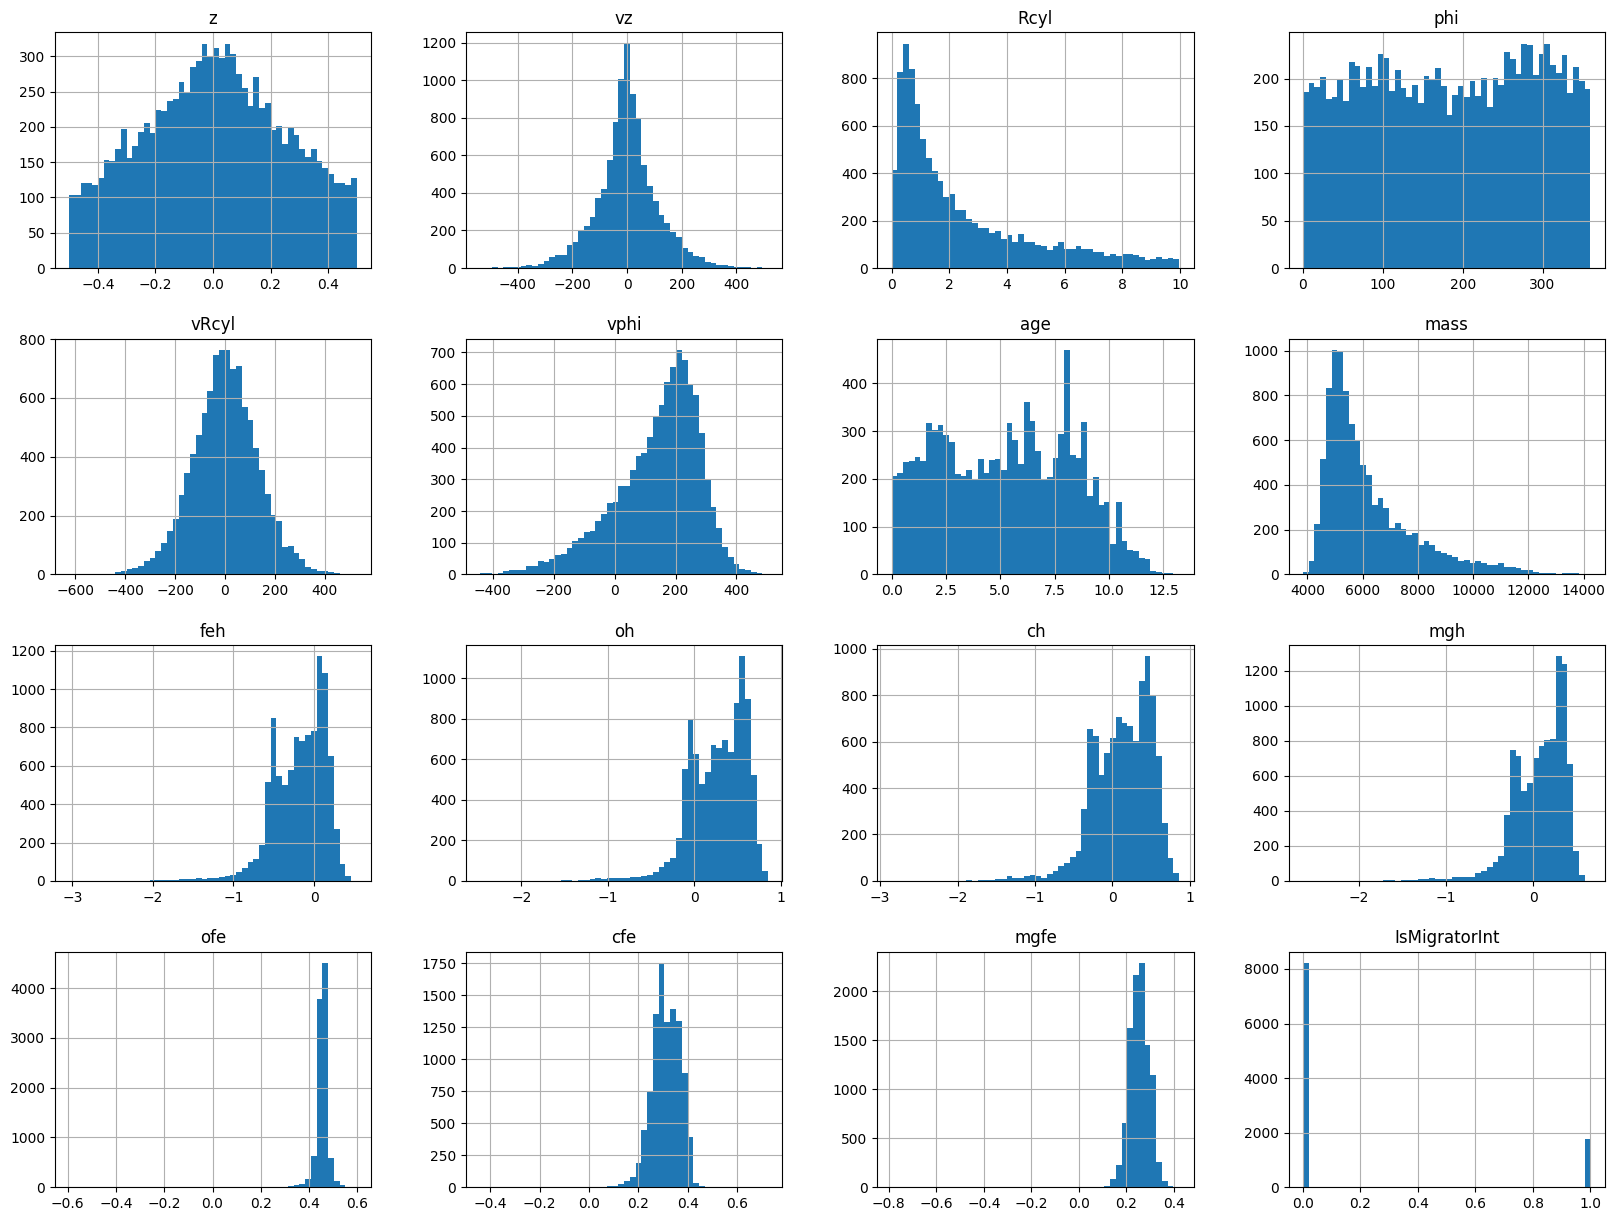

In [9]:
#make histogram of each column 
DataFinal.hist(bins=50, figsize=(20,15));
plt.savefig(PathToRepo + '\\Plots\\histogram_with_outlier.png')

Percentage of migrator stars in the fina data

In [10]:
DataFinal['IsMigratorInt'].sum()/len(DataFinal['IsMigratorInt'])

0.1775

In [11]:
# Look at the datapoints that has 'ofe' less than 0.2 as they might be outliers
potential_outliers_ofe = DataFinal[DataFinal['ofe'] < 0.2]
potential_outliers_ofe

,z,vz,Rcyl,phi,vRcyl,vphi,age,mass,feh,oh,ch,mgh,ofe,cfe,mgfe,IsMigratorBool,IsMigratorInt
1960,0.035,286.296,0.592,296.040,19.960,-95.910,8.009,5001.054,-0.287,-0.122,-0.207,-0.281,0.164,0.080,0.005,False,0
3421,-0.238,-69.483,1.004,348.886,-121.254,-212.352,8.787,4345.667,-0.260,-0.098,-0.194,-0.256,0.163,0.066,0.005,False,0
4526,-0.173,-6.075,4.116,12.092,38.982,-152.436,11.728,4511.690,-0.582,-1.176,-1.022,-1.371,-0.594,-0.440,-0.788,True,1
9819,-0.495,29.876,5.262,219.212,-322.773,81.001,5.422,8064.787,0.530,0.667,0.539,0.475,0.137,0.009,-0.055,True,1


So we see that it is actually only a single one of these that have a very different value (datapoint 4526) which has -0.594. <br>
Now looking at mgfe we see

In [12]:
potential_outliers_mgfe = DataFinal[DataFinal['mgfe'] < 0.0]
potential_outliers_mgfe

,z,vz,Rcyl,phi,vRcyl,vphi,age,mass,feh,oh,ch,mgh,ofe,cfe,mgfe,IsMigratorBool,IsMigratorInt
4526,-0.173,-6.075,4.116,12.092,38.982,-152.436,11.728,4511.690,-0.582,-1.176,-1.022,-1.371,-0.594,-0.440,-0.788,True,1
9819,-0.495,29.876,5.262,219.212,-322.773,81.001,5.422,8064.787,0.530,0.667,0.539,0.475,0.137,0.009,-0.055,True,1


Once again it is only datapoint 4526 that has a very small mgfe value. This makes sense since they are all related to the iron

In [13]:
potential_outliers_cfe = DataFinal[DataFinal['cfe'] < -0.1]
potential_outliers_cfe

,z,vz,Rcyl,phi,vRcyl,vphi,age,mass,feh,oh,ch,mgh,ofe,cfe,mgfe,IsMigratorBool,IsMigratorInt
4526,-0.173,-6.075,4.116,12.092,38.982,-152.436,11.728,4511.69,-0.582,-1.176,-1.022,-1.371,-0.594,-0.44,-0.788,True,1


In [14]:
potential_outliers_oh = DataFinal[DataFinal['oh'] < -1.5]
#potential_outliers_oh

In [15]:
potential_outliers_mgh = DataFinal[DataFinal['mgh'] < -1.5]
#potential_outliers_mgh

We try and drop this 4526 and do the historgrams again. 

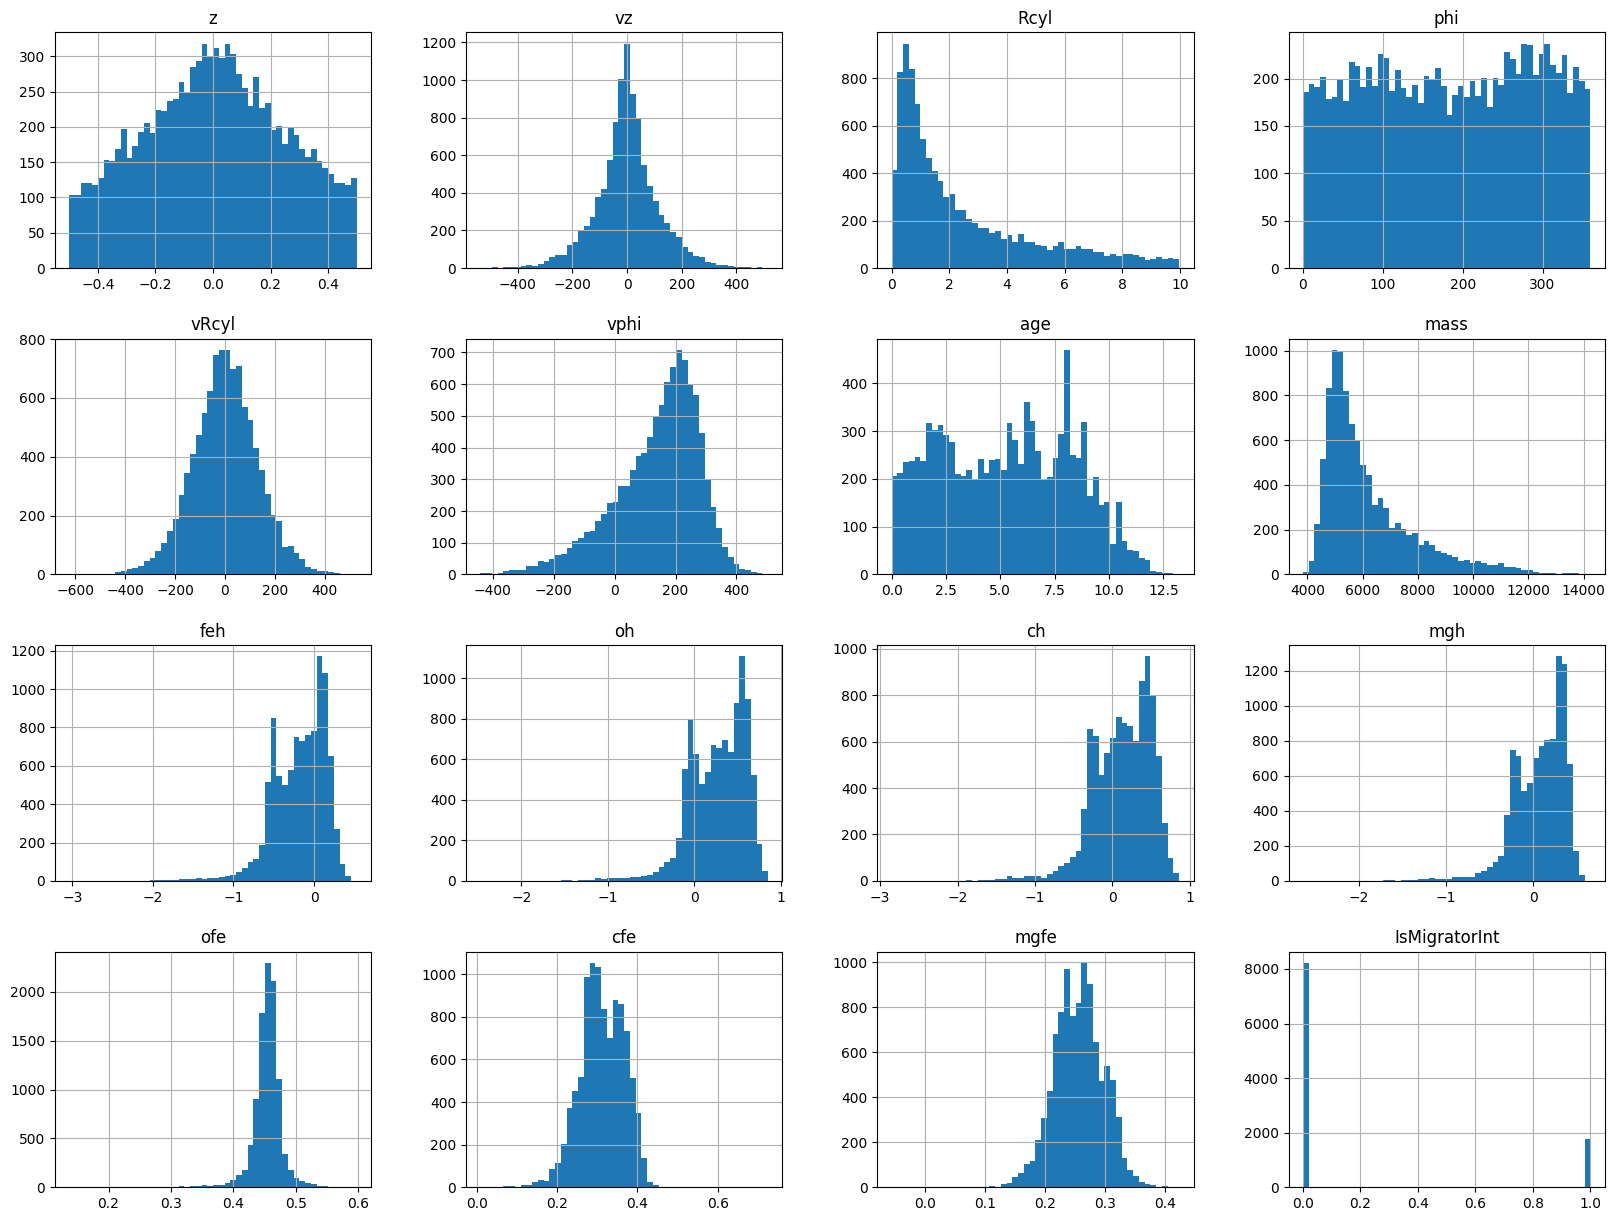

In [16]:
#Drop row 4526 as it is an outlier
DataFinal = DataFinal.drop([4526])
#Save as new csv file where we drop the 'IsMigratorBool' column and have removed the outlier
#Drop the column 
DataFinal = DataFinal.drop(['IsMigratorBool'], axis = 1)
DataFinal.to_csv(PathToRepo + '\\Data\\Faellesdata_cleaned.csv', index = False)

DataFinal.hist(bins=50, figsize=(20,15));
plt.savefig(PathToRepo + '\\Plots\\histogram_without_outlier.png')

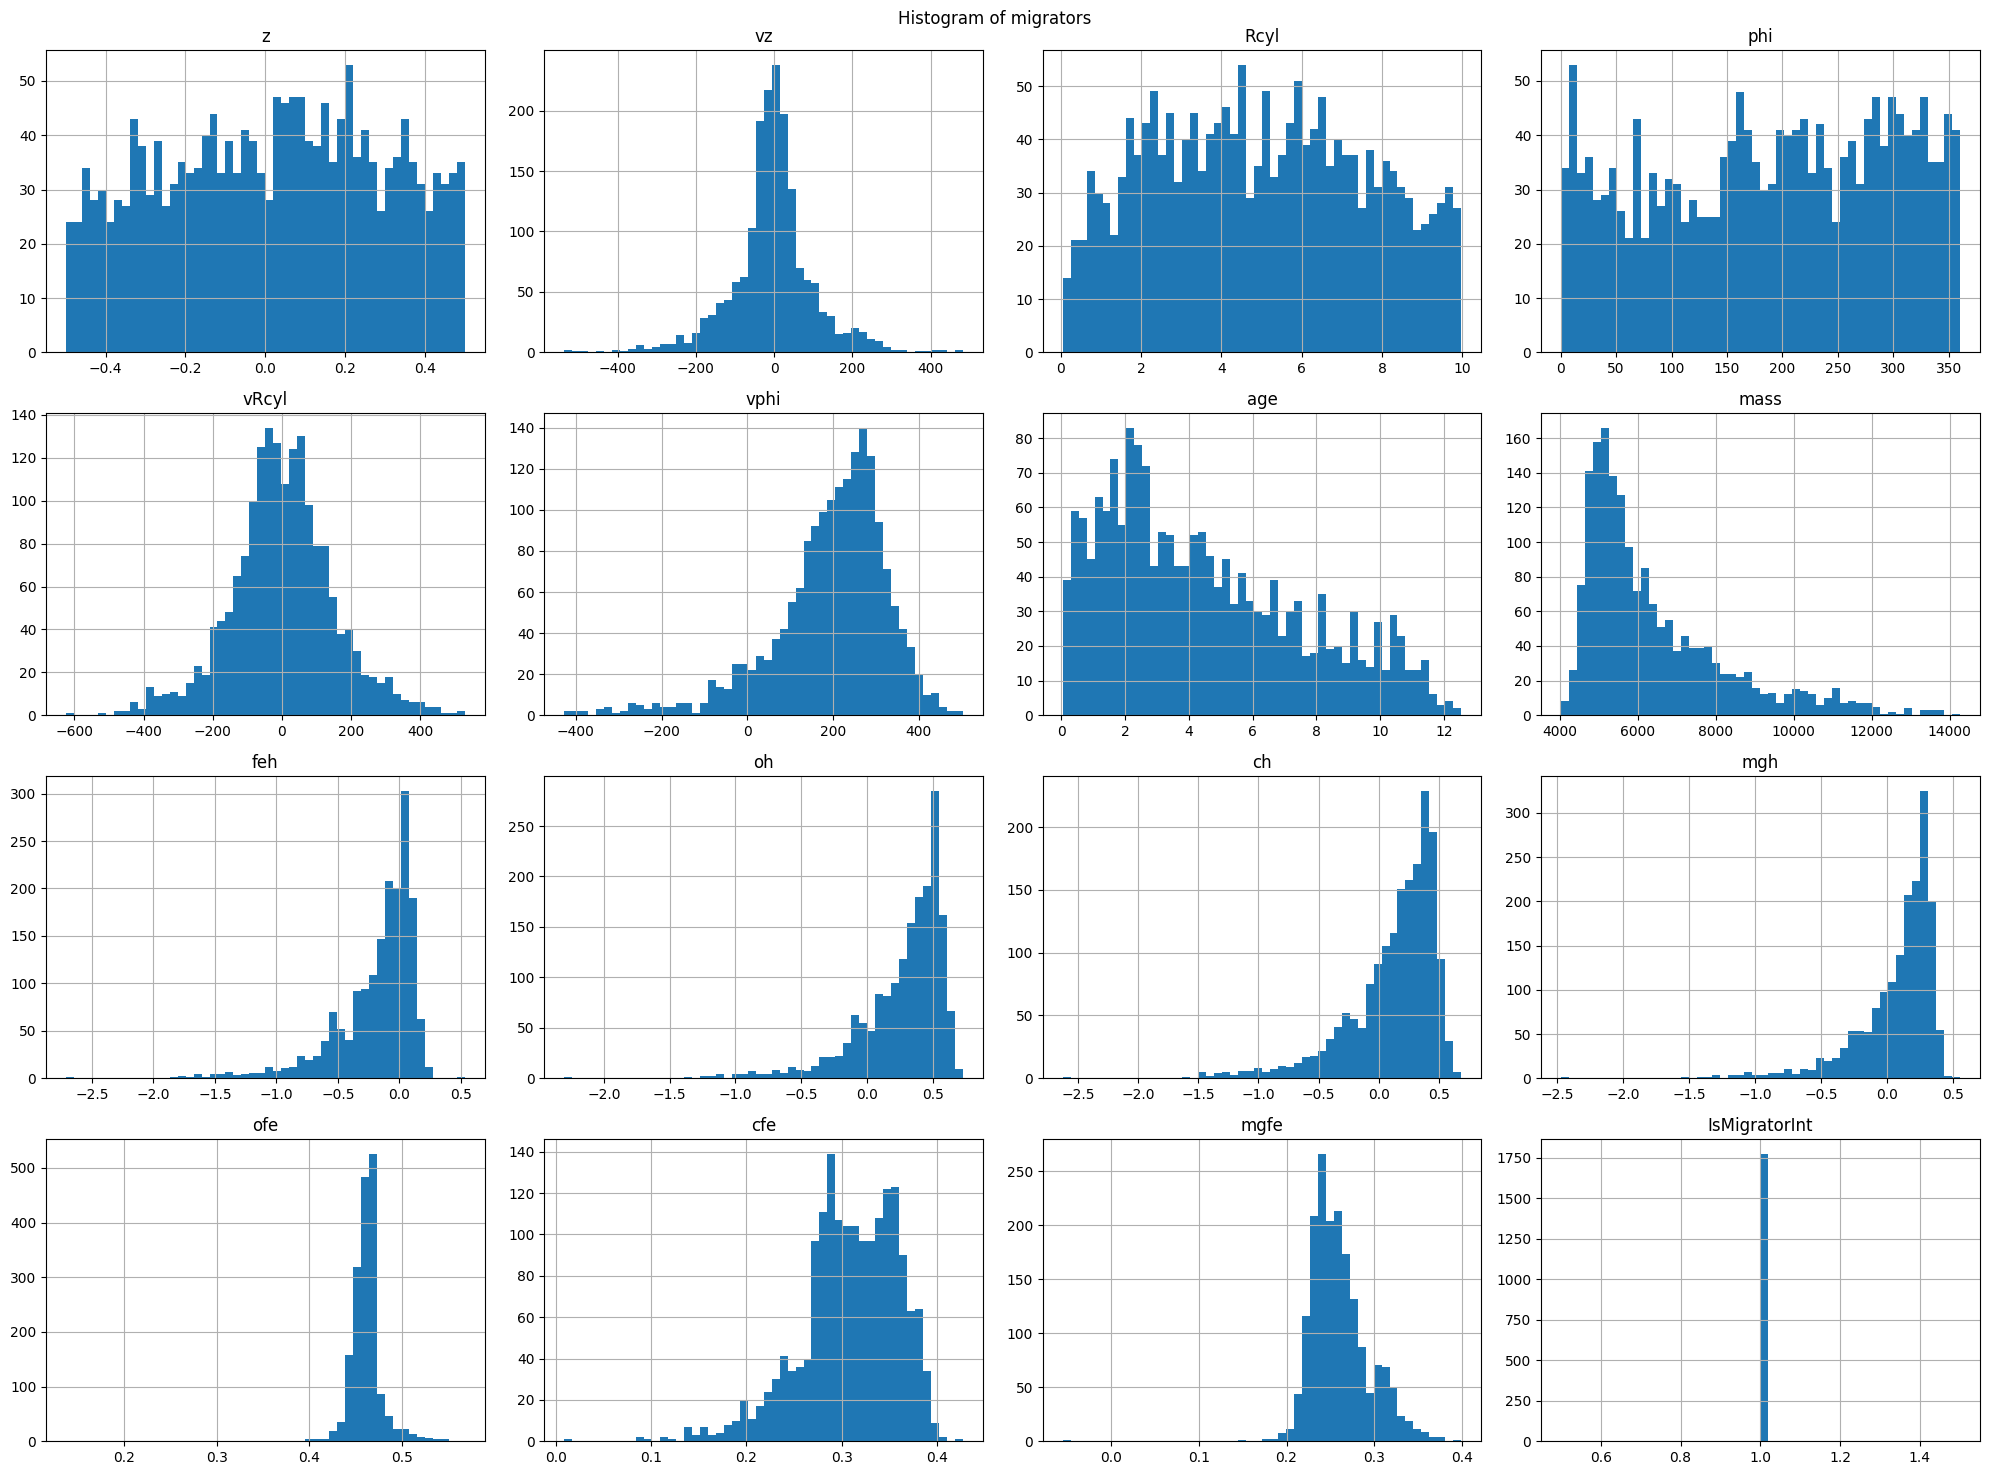

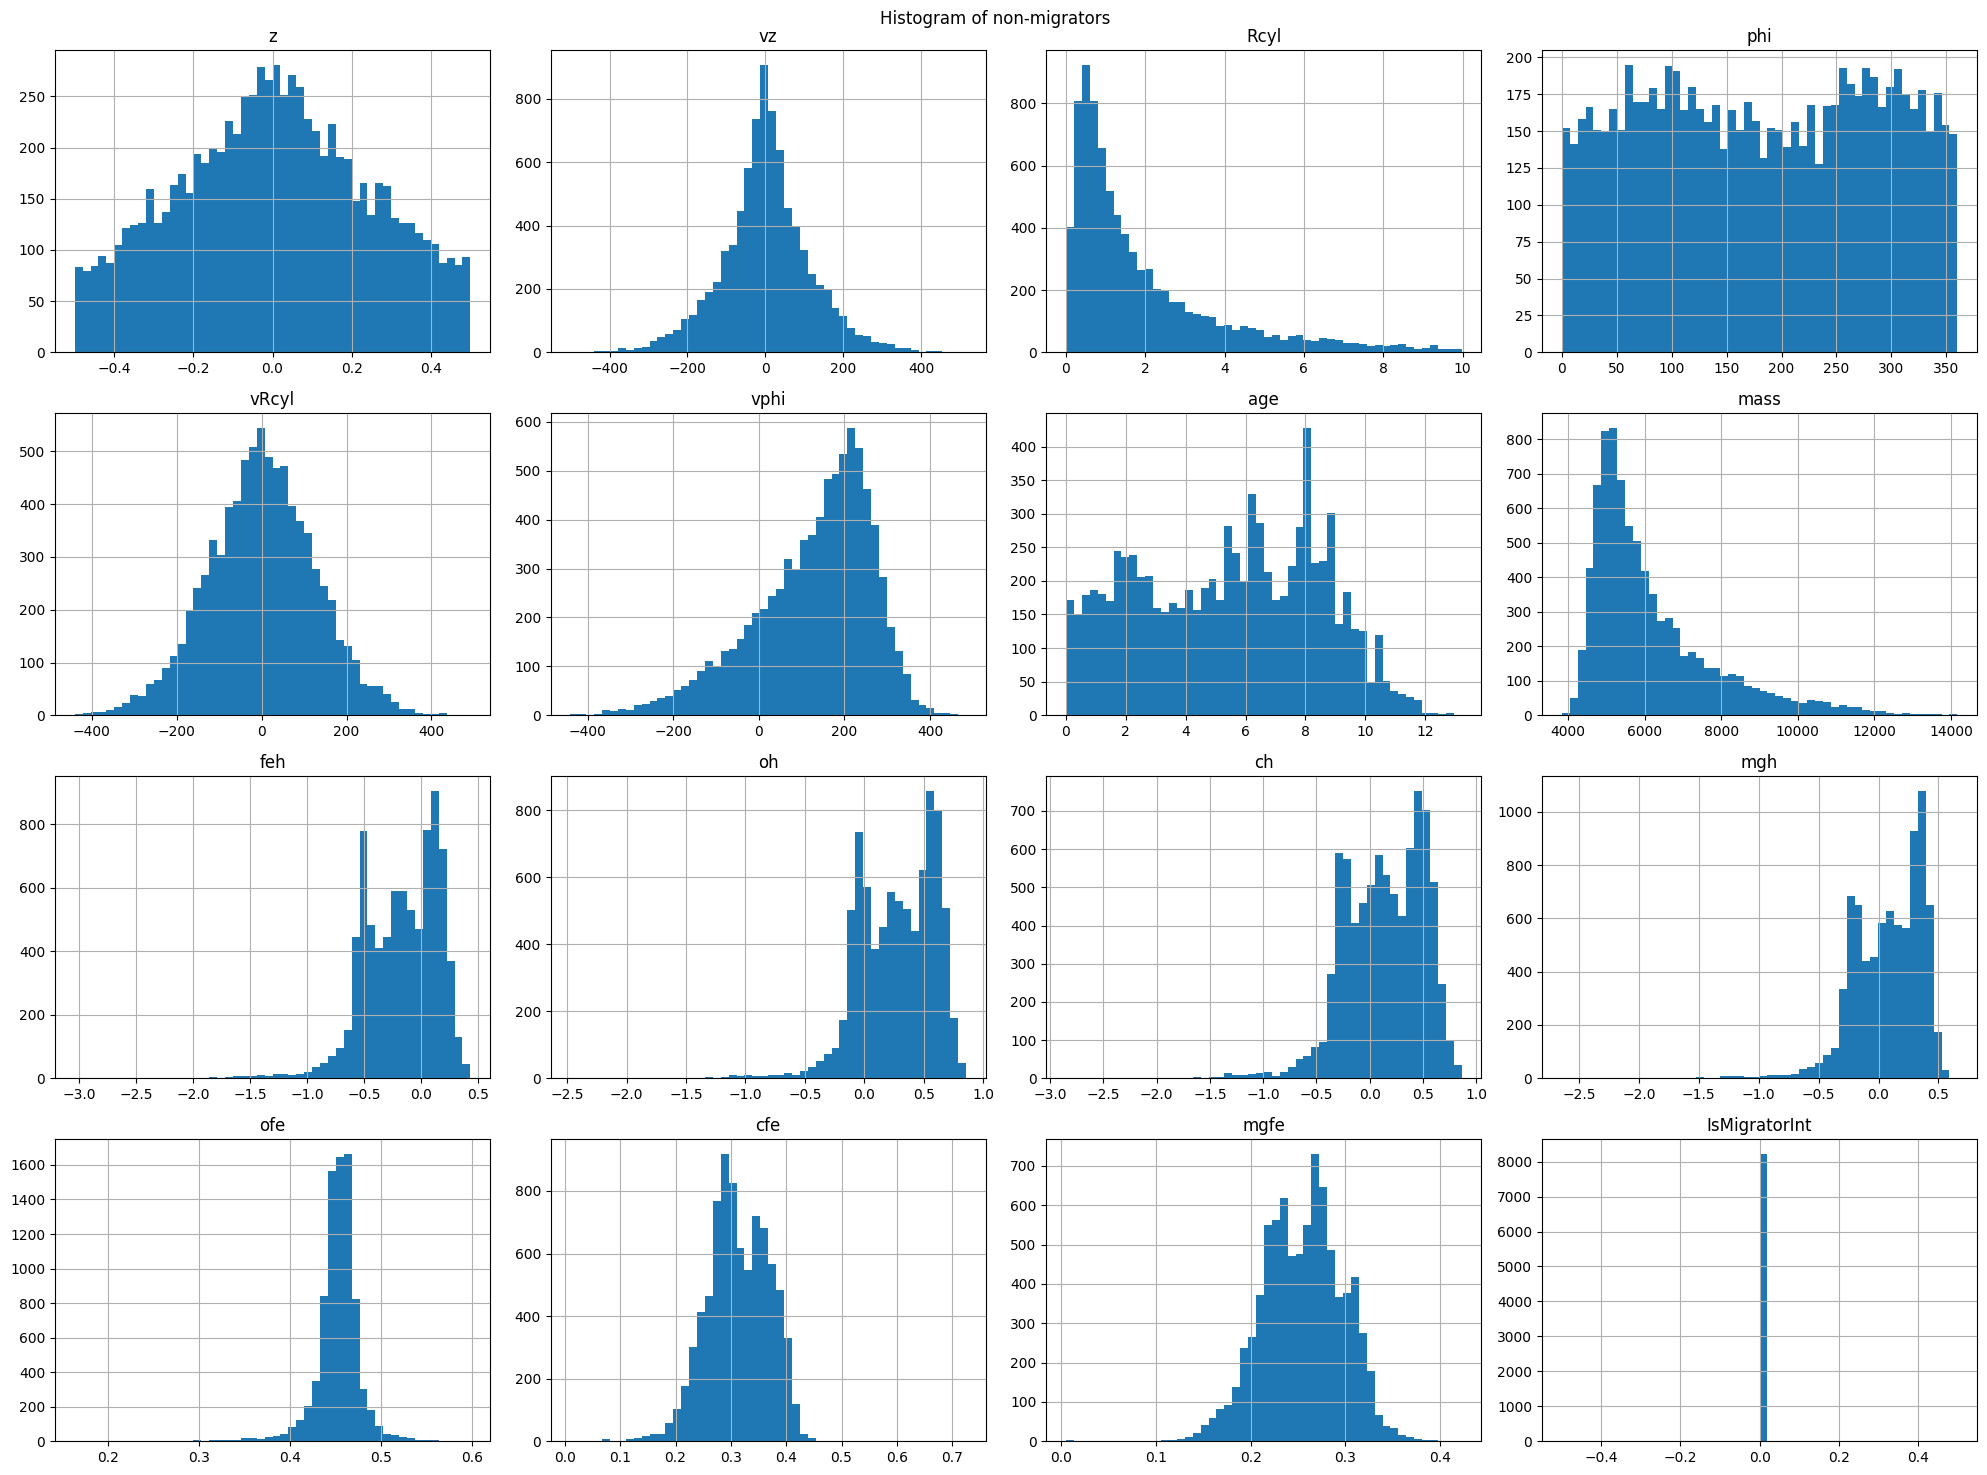

In [25]:
mask1 = DataFinal['IsMigratorInt'] == 1
mask0 = DataFinal['IsMigratorInt'] == 0

DataFinal[mask1].hist(bins=50, figsize=(20,15))
plt.suptitle('Histogram of migrators')
plt.tight_layout()
plt.savefig(PathToRepo + '\\Plots\\histogram_migrators.png')
plt.show()

DataFinal[mask0].hist(bins=50, figsize=(20,15));
plt.suptitle('Histogram of non-migrators')
plt.tight_layout()
plt.savefig(PathToRepo + '\\Plots\\histogram_non_migrators.png')
plt.show()

